# Using CTGAN to synthesise data

Source: https://github.com/sdv-dev/CTGAN

- Uses Python to generate synthetic data
- Uses R for evaluation 

In [2]:
from ctgan import CTGANSynthesizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load dataset

In [49]:
df = pd.read_csv("./original_data/satgpa.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sex      1000 non-null   int64  
 1   sat_v    1000 non-null   int64  
 2   sat_m    1000 non-null   int64  
 3   sat_sum  1000 non-null   int64  
 4   hs_gpa   1000 non-null   float64
 5   fy_gpa   1000 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 47.0 KB


In [50]:
df.head()

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,1,65,62,127,3.40,3.18
1,2,58,64,122,4.00,3.33
2,2,56,60,116,3.75,3.25
3,1,42,53,95,3.75,2.42
4,1,55,52,107,4.00,2.63


In [51]:
# Set discrete columns
discrete_cols = [
    'sex'
]

## Generate synthetic data

In [117]:
# Initialise and fit GAN
model = CTGANSynthesizer(batch_size=250, discriminator_steps=3, generator_lr=2e-3, discriminator_lr=2e-3)
model.fit(df, discrete_cols)

C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 

Can ignore warnings as per developer's comments: https://github.com/sdv-dev/SDGym/issues/44

In [118]:
synth_df = model.sample(1000)

In [119]:
synth_df.head()

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,2,46,49,115,2.702203,0.778283
1,1,56,40,107,3.737025,1.611227
2,2,43,50,92,3.141036,2.460096
3,1,22,56,64,2.575029,0.508691
4,2,41,57,93,2.660033,2.414813


In [120]:
# Output
synth_output = "./synth_data/ctgan_method.csv"

In [121]:
synth_df.to_csv(synth_output, sep=",")

## Evaluation

We used an R package called Synthpop to perform evaluations. This lets us compare with CART methods.

In [6]:
# Read in synth data
synth_df = pd.read_csv(synth_output)

In [22]:
# Enables R in the notebook, only need to run once
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [89]:
%%R -i df,synth_df

suppressMessages(library(dplyr))

real_n <- df %>%
    count(sex) %>%
    mutate(freq = n / sum(n))
    
male_n <- real_n[which(real_n$sex == 1), "n"]
female_n <- real_n[which(real_n$sex == 2), "n"]

synth_n <- synth_df %>%
    count(sex) %>%
    mutate(freq = n / sum(n),
          p_score = case_when(sex == 1 ~ n / (n + male_n),
                             sex == 2 ~ n / (n + female_n)))

print("Frequency of sex: Real")
print(real_n)
print("Frequency of sex: Synthetic")
print(synth_n)

[1] "Frequency of sex: Real"
  sex   n  freq
1   1 516 0.516
2   2 484 0.484
[1] "Frequency of sex: Synthetic"
  sex   n  freq   p_score
1   1 529 0.529 0.5062201
2   2 471 0.471 0.4931937


Since propensity score for sex is near 0.5, we can see the distribution of sex is similar between synthetic vs. real data.

### Visualise
First, we visualise the univariate distributions for each variable.


Comparing percentages observed with synthetic

Press return for next variable(s): 


Selected utility measures:
           S_pMSE df
sex      0.324171  1
sat_v   18.598443  4
sat_m    3.589340  4
sat_sum 26.971762  4
hs_gpa  11.471270  4
fy_gpa   6.664635  4


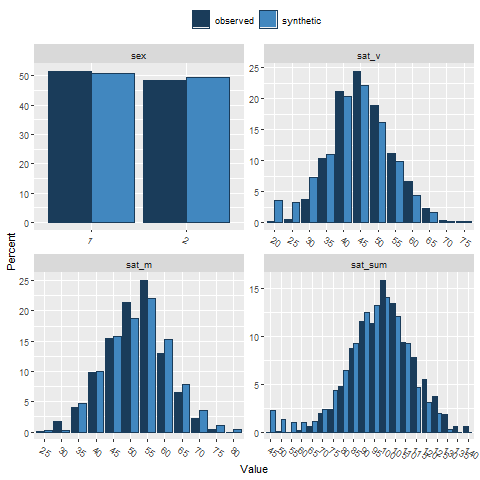

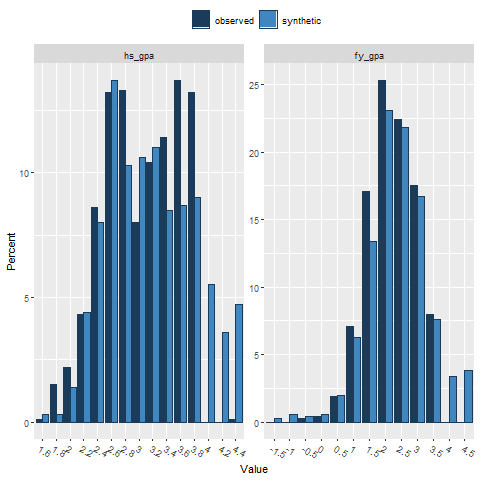

In [122]:
%%R -i df,synth_df

library(synthpop)

synthpop::compare(synth_df, df, utility.stats = c("S_pMSE", "df"))

### Utility scores

Visualises utility for all two-way tables.

A higher utility score is worse.


Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
 3.sat_m:4.sat_sum  2.sat_v:4.sat_sum 4.sat_sum:5.hs_gpa 4.sat_sum:6.fy_gpa 
           33.9646            27.0094            16.2696            12.5488 
   1.sex:4.sat_sum 
           12.4941 

Table of selected utility measures
                         VW        FT    JSD SPECKS  WMabsDD        U        G
1.sex:2.sat_v       84.5611   85.7171 0.0154  0.114  28.4872 578423.5  89.6635
1.sex:3.sat_m       38.9663   39.6063 0.0071  0.060  15.6097 546805.5  42.1274
1.sex:4.sat_sum    112.4468  114.0993 0.0205  0.132  33.0033 593675.0 114.3115
1.sex:5.hs_gpa      63.0363   63.6008 0.0114  0.108  27.3019 570815.5  64.9186
1.sex:6.fy_gpa      29.2581   29.3990 0.0053  0.065  16.3383 546463.5  30.1264
2.sat_v:3.sat_m    201.0083  210.8243 0.0374  0.177  74.1373 615771.0 235.9767
2.sat_v:4.sat_sum  648.2246  816.7724 0.1315  0.331 140.4750 721818.0 743.6771
2.sat_v:5.h

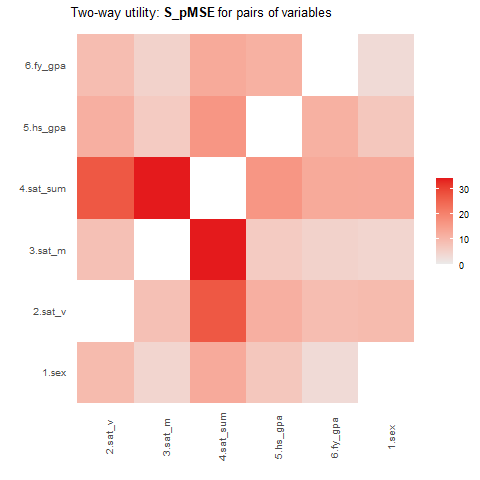

In [123]:
%%R -i df,synth_df

utility.tables(synth_df, df, tab.stats = "all", tables = "twoway", print.tabs = TRUE)